## **Implemention of The Neuron Network**

---

### **- MNIST Dataset**

#### **bill_length_mm VS bill_depth_mm**
Using "bill_length_mm" and "bill_depth_mm" of species "Gentoo" in Palmer Penguins Dataset to find the linear regression model.

In [30]:
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt

# Use the keras module to import the necessary data 
(train_X, train_y), (test_X, test_y) = keras.datasets.mnist.load_data()

train_y[1] = 0 



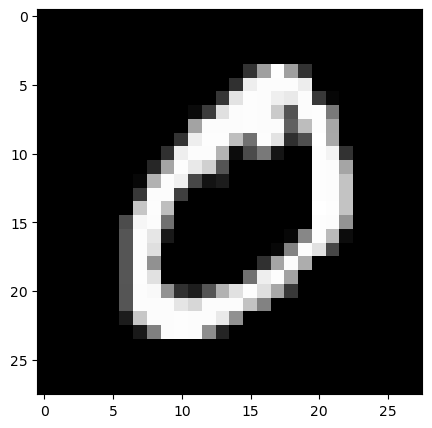

In [31]:
print(f"{train_y[1] = } \n")
plt.figure(figsize=(6, 5))
plt.imshow(train_X[1], cmap="gray")
plt.show()

In [32]:
# Scale the data for training. 
train_X = train_X/255
test_X = test_X/255

# Flatten the training images into coloumn vectors. 
flat_train_X = []
# One hot encode the training labels
onehot_train_y = []

for x, y in zip(train_X, train_y):
    flat_train_X.append(x.flatten().reshape(784, 1))
    temp_vec = np.zeros((10, 1))
    temp_vec[y][0] = 1.0
    onehot_train_y.append(temp_vec)
   

# Do the same for the testing data 
flat_test_X = []
onehot_test_y = []

for x, y in zip(test_X, test_y):
    flat_test_X.append(x.flatten().reshape(784, 1))
    temp_vec = np.zeros((10, 1))
    temp_vec[y] = 1.0
    onehot_test_y.append(temp_vec)

In [33]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z)*(1.0 - sigmoid(z))

def mse(a, y):
    return .5*sum((a[i] - y[i])**2 for i in range(10))[0]

In [34]:
def initialize_weights(layers = [784, 60, 60, 10]):
    # The following Python lists will contain numpy matrices
    # connected the layers in the neural network 
    W = [[0.0]]
    B = [[0.0]]
    for i in range(1, len(layers)):
        # The scalling factor is something I found in a research paper :)
        w_temp = np.random.randn(layers[i], layers[i-1])*np.sqrt(2/layers[i-1])
        b_temp = np.random.randn(layers[i], 1)*np.sqrt(2/layers[i-1])
    
        W.append(w_temp)
        B.append(b_temp)
    return W, B

In [35]:
W, B = initialize_weights()

xi = flat_train_X[0]
yi = onehot_train_y[0]
a0 = xi

def forward_pass(W, B, xi, predict_vector = False):
    Z = [[0.0]]
    A = [xi]
    L = len(W) - 1
    for i in range(1, L + 1):
        z = W[i] @ A[i-1] + B[i]
        Z.append(z)
        
        a = sigmoid(z)
        A.append(a)
        
    if predict_vector == False:
        return Z, A
    else:
        return A[-1]

def predict(W, B, xi):
    _, A = forward_pass(W, B, xi)
    return np.argmax(A[-1])

y_hat = forward_pass(W, B, flat_train_X[0], predict_vector=True)
print(f"Prediction: np.argmax(y_hat) = {np.argmax(y_hat)}")
print(f"Target Label: np.argmax(yi) = {np.argmax(yi)}")
print(f"mse(y_hat, yi) = {mse(y_hat, yi)}")

Prediction: np.argmax(y_hat) = 9
Target Label: np.argmax(yi) = 5
mse(y_hat, yi) = 1.3907243816192503


In [36]:
def random_experiment(W, B, data_features, data_labels):
    i = np.random.randint(len(data_features))
    print(f"Actual label: {np.argmax(data_labels[i])}")
    print(f"Predicted label: {predict(W, B, data_features[i])}")
    

def MSE(W, B, X, y):
    cost = 0.0
    m = 0
    for xi, yi in zip(X, y):
        a = forward_pass(W, B, xi, predict_vector = True)
        cost += mse(a, yi)
        m+=1
    return cost/m

In [37]:
print(f"MSE(W, B, flat_train_X, onehot_train_y) = {MSE(W, B, flat_train_X, onehot_train_y)} \n")

random_experiment(W, B, flat_train_X, onehot_train_y)

MSE(W, B, flat_train_X, onehot_train_y) = 1.3208430215540687 

Actual label: 5
Predicted label: 9


In [38]:
class DenseNetwork(object):
    def __init__(self, layers = [784, 60, 60, 10]):
        self.layers = layers
        self.W, self.B = initialize_weights(layers = self.layers)

    def train(self, X_train, y_train, alpha = 0.046, epochs = 4):
        # Print the initial mean squared error
        self.errors_ = [MSE(self.W, self.B, X_train, y_train)]
        print(f"Starting Cost = {self.errors_[0]}")

        # Find your sample size
        sample_size = len(X_train)

        # Find the number of non-input layers.
        L = len(self.layers) - 1

        # For each epoch perform stochastic gradient descent. 
        for k in range(epochs):
            # Loop over each (xi, yi) training pair of data.
            for xi, yi in zip(X_train, y_train):
                # Use the forward pass function defined before
                # and find the preactivation and postactivation values.
                Z, A = forward_pass(self.W, self.B, xi)

                # Store the errors in a dictionary for clear interpretation
                # of computation of these values.
                deltas = dict()

                # Compute the output error 
                output_error = (A[L] - yi)*d_sigmoid(Z[L])
                deltas[L] = output_error

                # Loop from L-1 to 1. Recall the right entry of the range function 
                # is non-inclusive. 
                for i in range(L-1, 0, -1):
                    # Compute the node errors at each hidden layer
                    deltas[i] = (self.W[i+1].T @ deltas[i+1])*d_sigmoid(Z[i])

                # Loop over each hidden layer and the output layer to perform gradient 
                # descent. 
                for i in range(1, L+1):
                    self.W[i] -= alpha*deltas[i] @ A[i-1].T
                    self.B[i] -= alpha*deltas[i]

            # Show the user the cost over all training examples
            self.errors_.append(MSE(self.W, self.B, X_train, y_train))   
            print(f"{k + 1}-Epoch Cost = {self.errors_[-1]}")
    

    def predict(self, xi):
        depth = len(self.layers)
        _, A = forward_pass(self.W, self.B, xi)
        return np.argmax(A[-1])

MSE(net.W, net.B, flat_train_X, onehot_train_y) = 1.5619290799008179 

predicted digit is: 9
actual digit is: 9


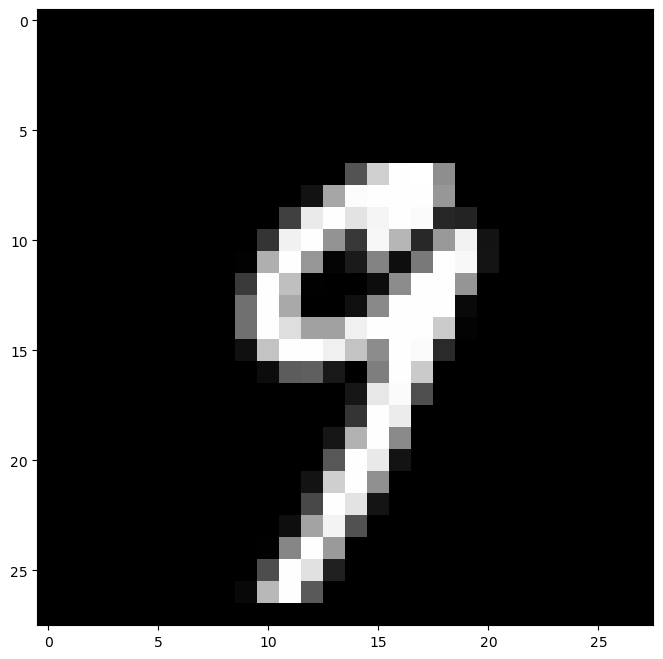

In [39]:
# Initialize a network with 784 input nodes, two hidden layers with 60 nodes each 
# and a output layer with 10 nodes. 
net = DenseNetwork(layers = [784, 120, 145, 120, 10])

# Check the mean squared error before training 
print(f"MSE(net.W, net.B, flat_train_X, onehot_train_y) = {MSE(net.W, net.B, flat_train_X, onehot_train_y)} \n")

# Make a random prediction before training
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()

In [40]:
net.train(flat_train_X, onehot_train_y)

Starting Cost = 1.5619290799008179
1-Epoch Cost = 0.08418384176879161
2-Epoch Cost = 0.053032229504673054
3-Epoch Cost = 0.04028966453241855
4-Epoch Cost = 0.03162803187863727


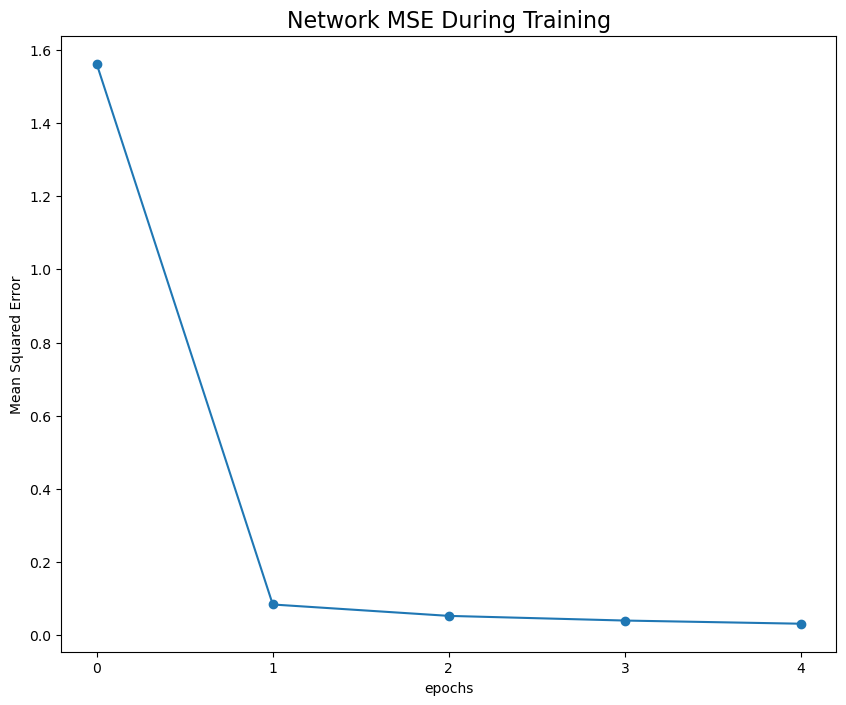

In [41]:
plt.figure(figsize = (10, 8))
epochs = range(len(net.errors_))
plt.plot(epochs, net.errors_, marker = "o")
plt.xticks(epochs)
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.title("Network MSE During Training", fontsize = 16)
plt.show()

predicted digit is: 5
actual digit is: 5


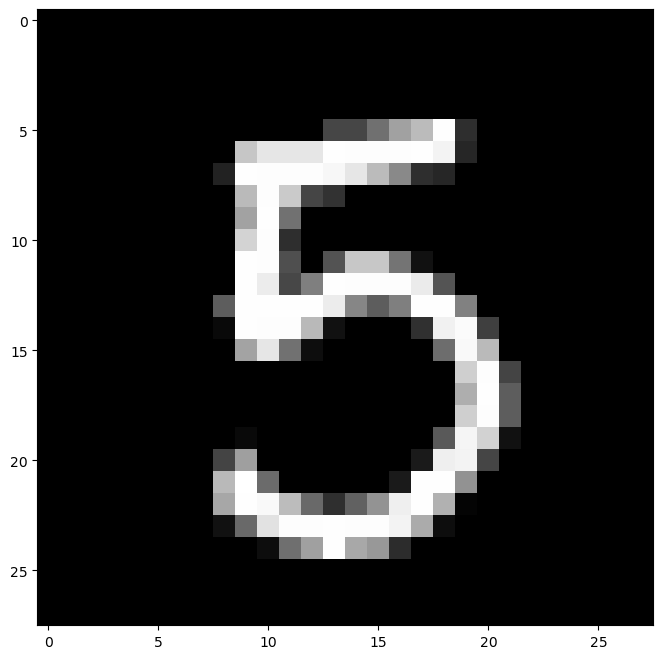

In [42]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()

predicted digit is: 4
actual digit is: 4


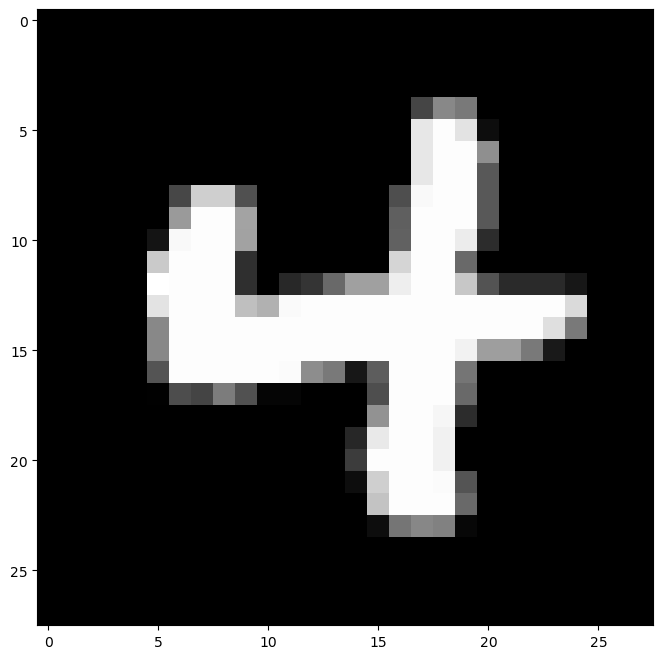

In [43]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()

predicted digit is: 9
actual digit is: 7


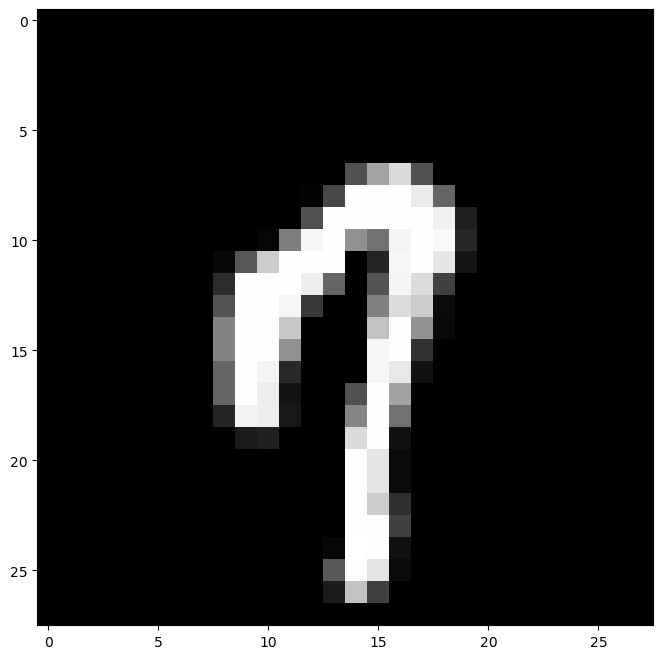

In [44]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()

predicted digit is: 0
actual digit is: 0


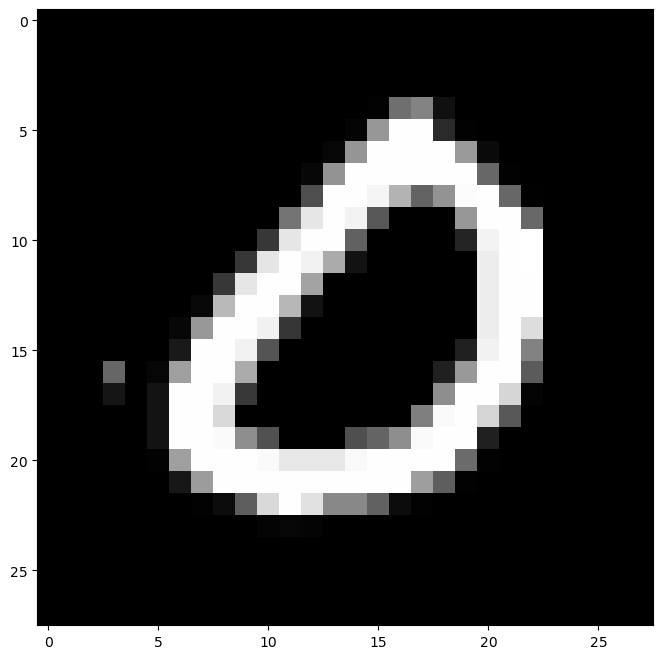

In [46]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(test_X[i], cmap="gray")
plt.show()

In [45]:
# Compute the classification accuracy of our trained model on the test data (I bet we did well!)
sum([int(net.predict(x) == y) for x, y in zip(flat_test_X, test_y)])/len(onehot_test_y)

0.9573